# Experiment from July 2, 2015.
Structure of stimulus:  
22.5 min Low contrast binary white noise  
22.5 min High contrast binary white noise  
22.5 min Low contrast binary white noise  
22.5 min High contrast binary white noise  
90 min natural scenes  
10 min of 1 min repeating natural scenes  
5 min high contrast white noise

In [1]:
import numpy as np
from sklearn.decomposition import PCA
import scipy.io
import itertools
import os
import h5py
import pyret
import binary     # in igor >> recording

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, xlabel, ylabel, title

# note that nonposx(y) for log plots will no longer work with this package
import mpld3
#mpld3.enable_notebook()

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Make animations play nicely in python notebook

In [37]:
from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)

from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

# Choose data directory

In [3]:
data_dir = os.path.expanduser('~/Documents/Stanford/00 Baccus Lab/Data 2015_08_13/')

# Load photodiode  
To align stimulus and recording. The stimulus is briefly (<500ms) a grey screen, followed by a white photodiode for the first frame.

In [5]:
photodiode_dir = '/Volumes/group/baccus/Lane/2015-08-13/'
first_bin_file = photodiode_dir + '150813a.bin'
raw_data = binary.readbin(first_bin_file, chanlist=[0])
header   = binary.readbinhdr(first_bin_file)

In [6]:
header['fs']

10000.0

In [14]:
# show first 10 seconds
disp_frames = range(4*int(header['fs']), 5*int(header['fs']))
plot(np.linspace(4, 5, len(disp_frames)), raw_data[disp_frames])
mpld3.display()

In [16]:
first_peak_start = 4.560
first_peak_end = 4.570
disp_frames = range(int(first_peak_start*header['fs']), int(first_peak_end*header['fs']))
first_white_peak  = np.argmax(raw_data[disp_frames])
first_white_ind   = first_white_peak + first_peak_start * header['fs']
time_stim_started = first_white_ind / header['fs']
print 'Stimulus started at %f seconds, relative to recording computer' %(time_stim_started)

Stimulus started at 4.564700 seconds, relative to recording computer


# Load spikes

In [17]:
fs = sorted(os.listdir(data_dir))
fs = [f for f in fs if f.endswith(".txt")]

cells = []
for f in fs:
    text_file = open(data_dir + f, "r")
    spikes = text_file.read().split('\n')
    cells.append([float(spike) - time_stim_started for spike in spikes if (not (not spike)) and float(spike) - time_stim_started > 0])
    
    text_file.close()

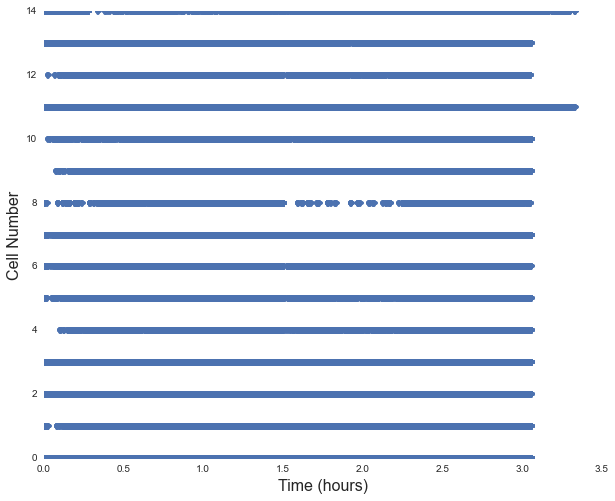

In [18]:
num_cells = len(cells)
all_spiking = np.hstack([ np.vstack((np.array(cell), np.ones(len(cell))*idx)) for idx, cell in enumerate(cells) ]).T
all_spiking.shape

plot(all_spiking[:,0]/(3600.), all_spiking[:,1], 'o')
xlabel('Time (hours)', fontsize=16)
ylabel('Cell Number', fontsize=16)

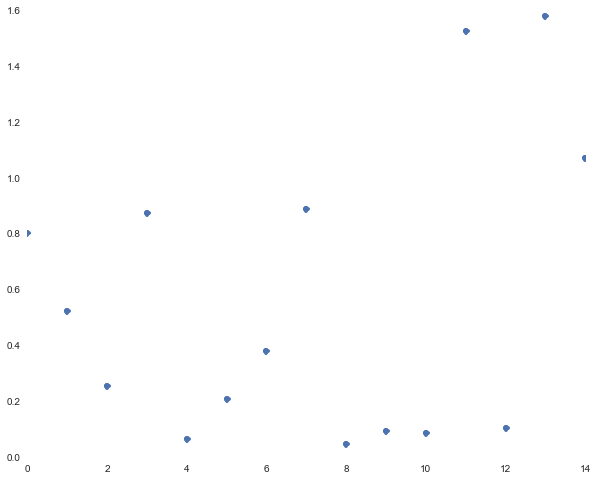

In [19]:
avg_spike_rate = [len(np.array(cells[i])[np.array(cells[i]) < 22.5*60.])/(22.5*60.) for i in range(len(cells))]
plot(avg_spike_rate, 'o')

# Load stimulus  
database is in format  
expt1/stim and expt1/timestamps  
for up to expt16

In [119]:
# stim_file = '/Volumes/data/Lane/2015-07-02/stimulus/stimulus.h5'
# stim_file = '/Volumes/LACIE DRIVE/Lane/2015_07_02/stimulus/stimulus.h5'
stim_file = data_dir + 'stimulus.h5'
f = h5py.File(stim_file)

# Low contrast

In [120]:
expt1_time = f['expt1/timestamps']
expt1 = np.array(f['expt1/stim']).T

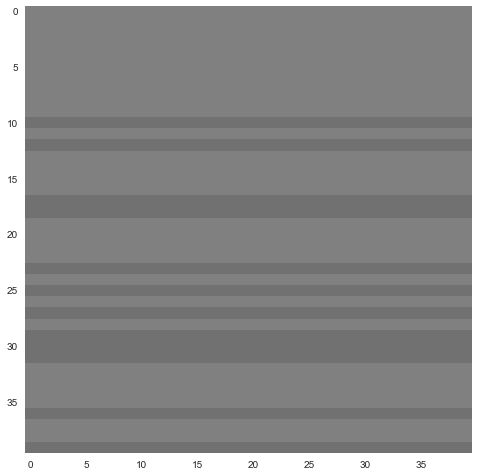

In [122]:
plt.imshow(np.tile(expt1[:,:,0], (1,40)), clim=[1,255])
plt.grid('off')

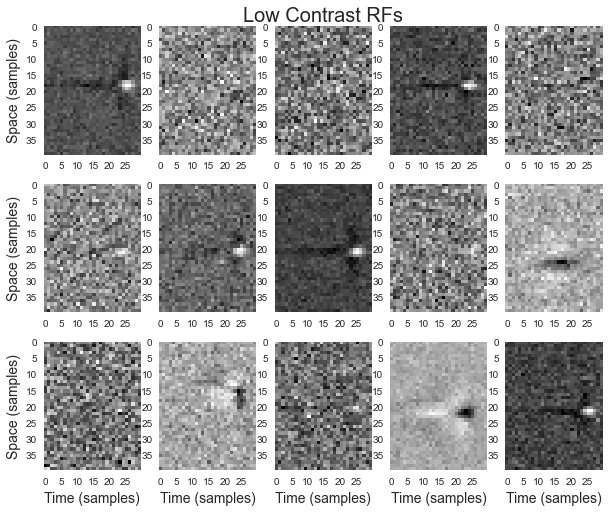

In [132]:
# Visualize the ganglion cell RFs.
num_cols = 5
num_rows = 3
idxs = range(num_cols)
for y in range(num_cols):
    for i in range(num_rows):
        plt_idx = i * num_cols + y + 1
        sta,tax = pyret.filtertools.getsta(expt1_time, expt1, cells[plt_idx-1], 30, norm=True)
        plt.subplot(num_rows, num_cols, plt_idx)
        plt.imshow(sta.squeeze())
        plt.grid('off')
        #plt.axis('off')
        if i == num_rows-1:
            plt.xlabel('Time (samples)', fontsize=14)
        if y == 0:
            plt.ylabel('Space (samples)', fontsize=14)
        if i == 0:
            if y == 2:
                plt.title('Low Contrast RFs', fontsize=20)

In [124]:
np.max(cells[neuron])/(3600.)

3.0520789444444443

# High contrast

In [116]:
expt2_time = f['expt2/timestamps'] + f['expt1/timestamps'][-1] + f['expt1/timestamps'][1]
expt2 = np.array(f['expt2/stim']).T

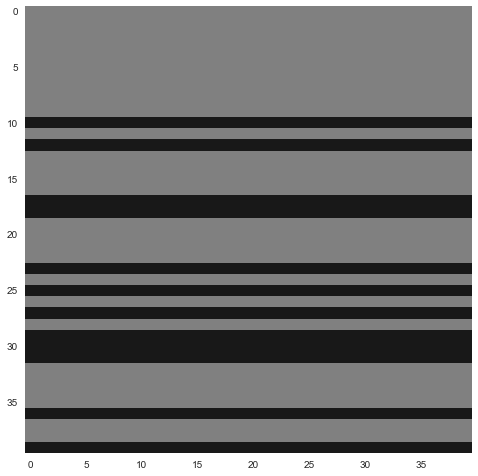

In [127]:
plt.imshow(np.tile(expt2[:,:,0], (1,40)), clim=[1,255])
plt.grid('off')

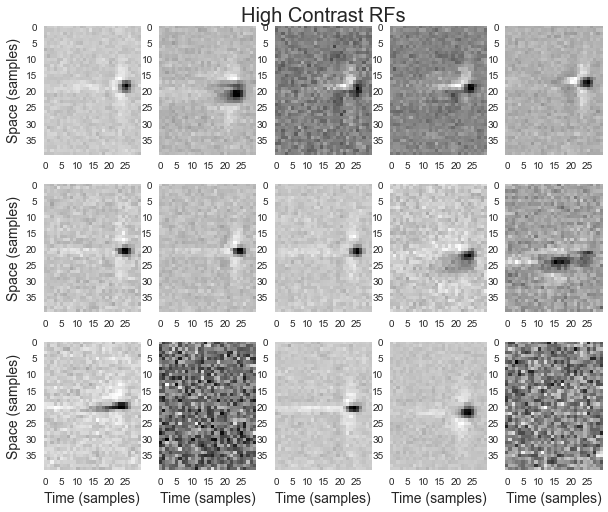

In [133]:
# Visualize the ganglion cell RFs.
num_cols = 5
num_rows = 3
idxs = range(num_cols)
for y in range(num_cols):
    for i in range(num_rows):
        plt_idx = i * num_cols + y + 1
        sta,tax = pyret.filtertools.getsta(expt2_time, expt2, cells[plt_idx-1], 30, norm=True)
        plt.subplot(num_rows, num_cols, plt_idx)
        plt.imshow(sta.squeeze())
        plt.grid('off')
        #plt.axis('off')
        if i == num_rows-1:
            plt.xlabel('Time (samples)', fontsize=14)
        if y == 0:
            plt.ylabel('Space (samples)', fontsize=14)
        if i == 0:
            if y == 2:
                plt.title('High Contrast RFs', fontsize=20)

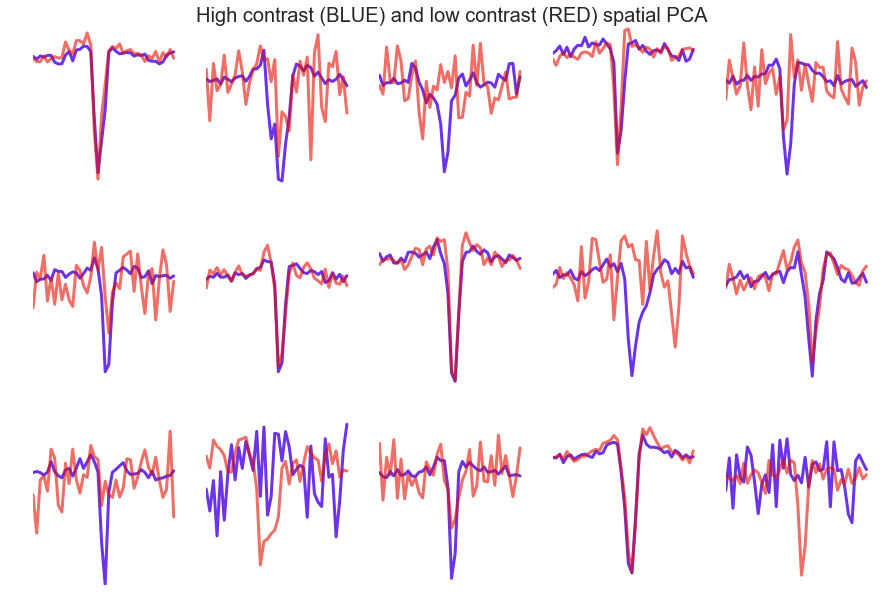

In [143]:
fig = plt.gcf()
fig.set_size_inches((15,10))
num_cols = 5
num_rows = 3
idxs = range(num_cols)
for y in range(num_cols):
    for i in range(num_rows):
        plt_idx = i * num_cols + y + 1
        sta_low, time_axis_low   = pyret.filtertools.getsta(expt1_time, expt1, cells[plt_idx-1], 30, norm=True)
        sta_high, time_axis_high = pyret.filtertools.getsta(expt2_time, expt2, cells[plt_idx-1], 30, norm=True)
        spatial_pca_high  = PCA(n_components=1)
        spatial_pca_high.fit(sta_high.squeeze().T)
        spatial_rf_high   = spatial_pca_high.components_[0]
        spatial_pca_low   = PCA(n_components=1)
        spatial_pca_low.fit(sta_low.squeeze().T)
        spatial_rf_low    = spatial_pca_low.components_[0]
        sign_high         = -1*np.sign(spatial_rf_high[np.argmax(abs(spatial_rf_high))])
        sign_low          = -1*np.sign(spatial_rf_low[np.argmax(abs(spatial_rf_low))])
        
        # plot the spatial receptive fields
        plt.subplot(num_rows, num_cols, plt_idx)
        plt.plot(sign_high * spatial_rf_high, color='#4700E6', alpha=0.8, linewidth=3)
        plt.plot(sign_low * spatial_rf_low, color='#E60E00', alpha=0.6, linewidth=3)
        plt.axis('off')
        if y == 2:
            if i == 0:
                plt.title('High contrast (BLUE) and low contrast (RED) spatial PCA', fontsize=20)

# Compare both 45 minute High Contrast stimuli segments

In [144]:
neuron = 0

In [148]:
expt4_time = f['expt4/timestamps'] + f['expt1/timestamps'][-1] + f['expt2/timestamps'][-1] + \
                f['expt3/timestamps'][-1] + 3*f['expt1/timestamps'][1]
expt4 = np.array(f['expt4/stim']).T
sta_trial_one, sta_taxis = pyret.filtertools.getsta(expt2_time, expt2, cells[neuron], 30, norm=True)
sta_trial_two, sta_taxis = pyret.filtertools.getsta(expt4_time, expt4, cells[neuron], 30, norm=True)

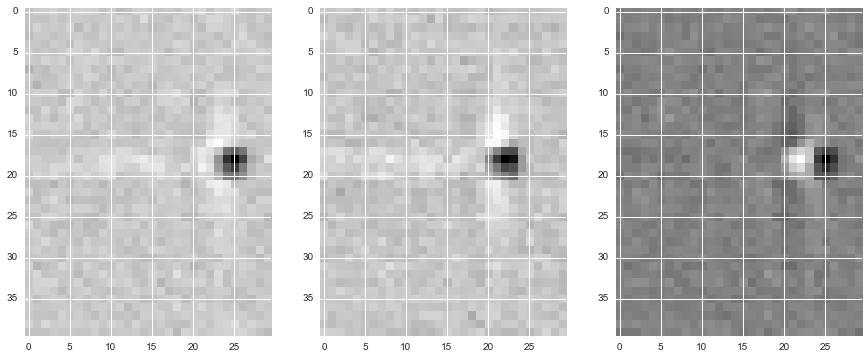

In [153]:
fig = plt.gcf()
fig.set_size_inches((15,10))
plt.subplot(1,3,1)
plt.imshow(sta_trial_one.squeeze())
plt.subplot(1,3,2)
plt.imshow(sta_trial_two.squeeze())
plt.subplot(1,3,3)
plt.imshow(sta_trial_one.squeeze() - sta_trial_two.squeeze())

# Compare both 45 minute Low Contrast stimuli segments

In [154]:
expt3_time = f['expt3/timestamps'] + f['expt1/timestamps'][-1] + f['expt2/timestamps'][-1] + \
            2*f['expt1/timestamps'][1]
expt3 = np.array(f['expt3/stim']).T
sta_trial_one, sta_taxis = pyret.filtertools.getsta(expt1_time, expt1, cells[neuron], 30, norm=True)
sta_trial_two, sta_taxis = pyret.filtertools.getsta(expt3_time, expt3, cells[neuron], 30, norm=True)

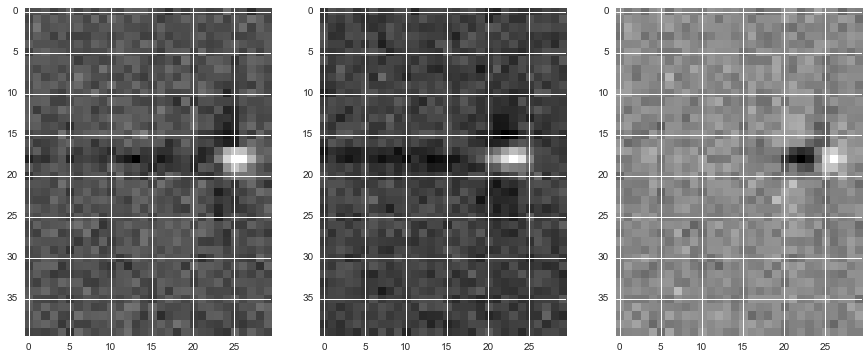

In [155]:
fig = plt.gcf()
fig.set_size_inches((15,10))
plt.subplot(1,3,1)
plt.imshow(sta_trial_one.squeeze())
plt.subplot(1,3,2)
plt.imshow(sta_trial_two.squeeze())
plt.subplot(1,3,3)
plt.imshow(sta_trial_one.squeeze() - sta_trial_two.squeeze())